<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/311664083.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')


Dataset loaded.
Index(['Unnamed: 0', 'userName', 'Title', 'Base_Reviews', 'Rating',
       'cleaned_Review', 'Have_Issue', 'Assessability Issue Type'],
      dtype='object')
NLTK data downloaded.


[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 61] Connection refused>
[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/311664083.py:41: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - accuracy: 0.6296 - loss: 0.6392 - val_accuracy: 0.7835 - val_loss: 0.4866
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.7937 - loss: 0.4667 - val_accuracy: 0.8171 - val_loss: 0.4186
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - accuracy: 0.8218 - loss: 0.4160 - val_accuracy: 0.8349 - val_loss: 0.3910
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.8343 - loss: 0.3968 - val_accuracy: 0.8156 - val_loss: 0.4123
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.6703 - loss: 0.6504 - val_accuracy: 0.7382 - val_loss: 0.5196
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - accuracy: 0.7652 - loss: 0.4971 - val_accuracy: 0.7748 - val_loss: 0.4570
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - accuracy: 0.8136 - loss: 0.4236 - val_accuracy: 0.8095 - val_loss: 0.4206
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 298ms/step - ac

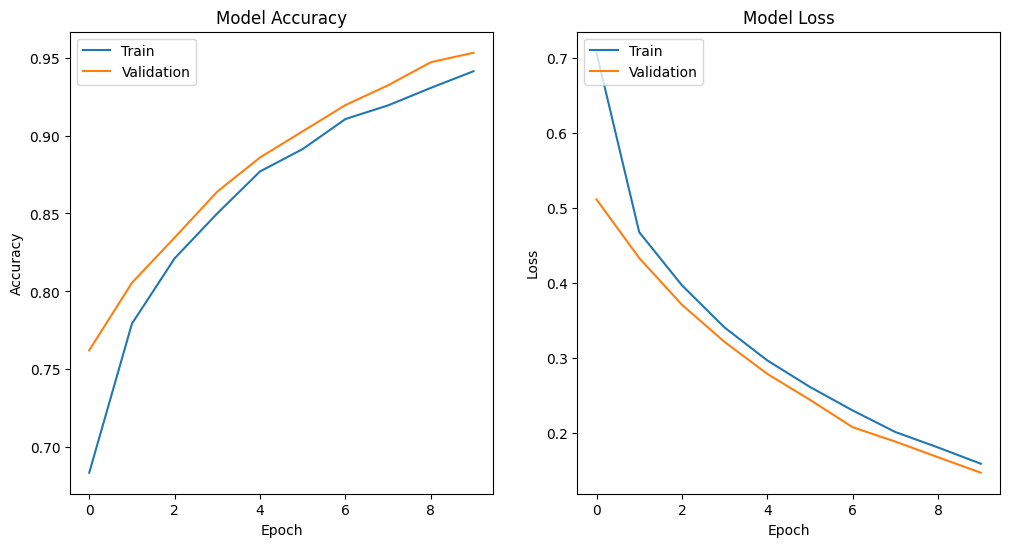

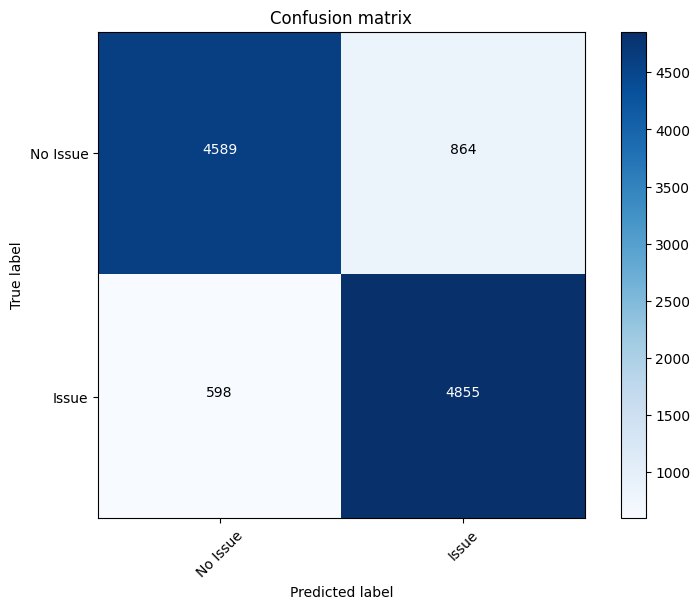

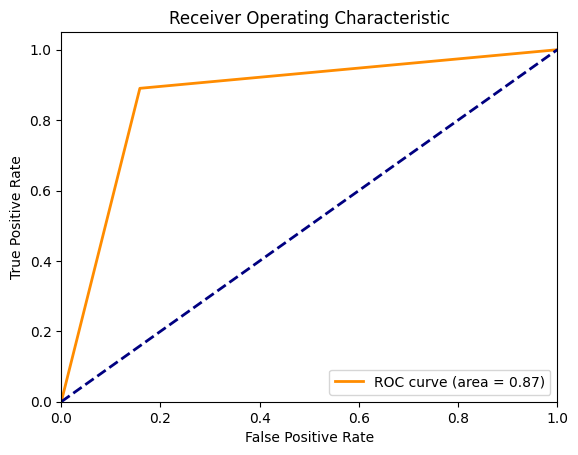

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      5453
           1       0.85      0.89      0.87      5453

    accuracy                           0.87     10906
   macro avg       0.87      0.87      0.87     10906
weighted avg       0.87      0.87      0.87     10906



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Accessibility issues new.csv', encoding='latin-1')
print("Dataset loaded.")
print(dataset.columns)
# Remove rows where the target variable has missing values
dataset = dataset.dropna(subset=['Have_Issue'])

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['Base_Reviews'] = dataset['Base_Reviews'].apply(clean_text)
dataset['Base_Reviews'].dropna(inplace=True)
dataset['Base_Reviews'] = [entry.lower() for entry in dataset['Base_Reviews']]
dataset['Base_Reviews'] = [word_tokenize(entry) for entry in dataset['Base_Reviews']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['Base_Reviews']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Issue'] = dataset['Have_Issue'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Issue']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the LSTM model
def build_LSTM_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
lstm_model = build_LSTM_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = lstm_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = lstm_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot for model accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot for model loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Save the figure before showing
    plt.savefig('training_validation_loss_accuracy_lstm.png', dpi=300)
    
    plt.show()


plot_history(history)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))  # Optional: Define the figure size
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_lstm.png', dpi=300)  # Save the plot with 300 DPI
    plt.show()

# Example usage:
# plot_confusion_matrix(y_true, y_pred, classes=['Class 1', 'Class 2'], title='Confusion matrix')


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('ROC_curve.png', dpi=300)  # Save the plot with 300 DPI
    plt.show()

# Example usage:
# plot_roc_curve(y_true, y_pred_proba)


# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Issue", "Issue"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/1169389806.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')


Dataset loaded.
Index(['Unnamed: 0', 'userName', 'Title', 'Base_Reviews', 'Rating',
       'cleaned_Review', 'Have_Issue', 'Assessability Issue Type'],
      dtype='object')
NLTK data downloaded.


[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 61] Connection refused>
[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/1169389806.py:41: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - accuracy: 0.6526 - loss: 0.6263 - val_accuracy: 0.6414 - val_loss: 0.6264
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - accuracy: 0.7833 - loss: 0.4709 - val_accuracy: 0.7648 - val_loss: 0.5410
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step - accuracy: 0.8296 - loss: 0.3894 - val_accuracy: 0.7666 - val_loss: 0.5484
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.7088 - loss: 0.5890 - val_accuracy: 0.6995 - val_loss: 0.6218
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.7841 - loss: 0.4575 - val_accuracy: 0.7214 - val_loss: 0.6048
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - accuracy: 0.8249 - loss: 0.4088 - val_accuracy: 0.7666 - val_loss: 0.5567
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step - accuracy: 0.8305 - loss: 0.3845 - val_accuracy: 0.7312 - val_loss: 0.6348
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/10
66/66 

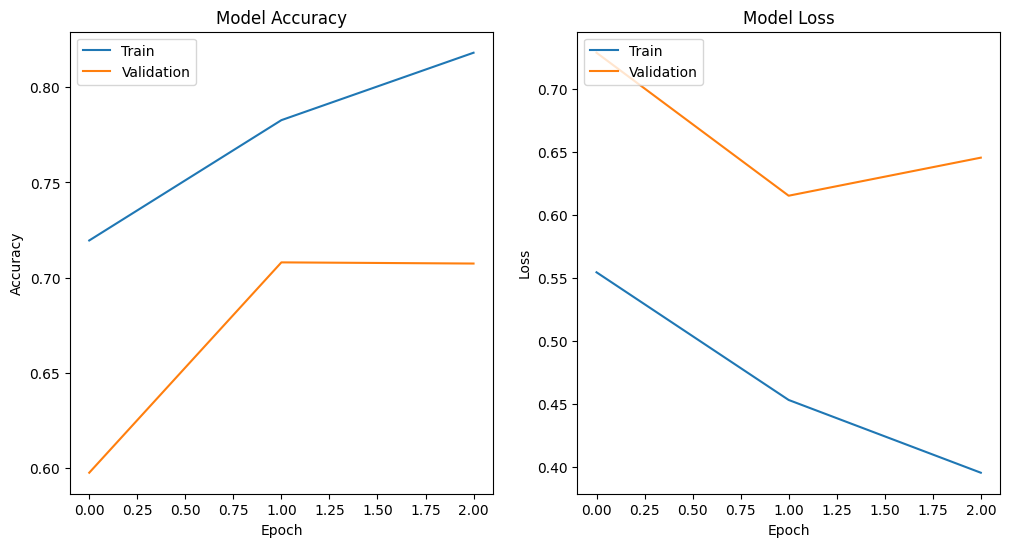

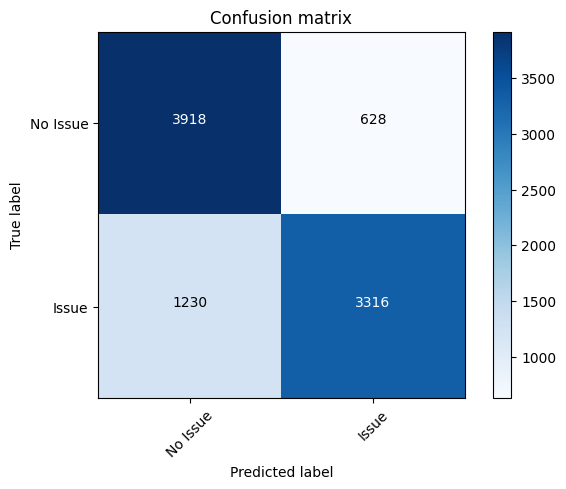

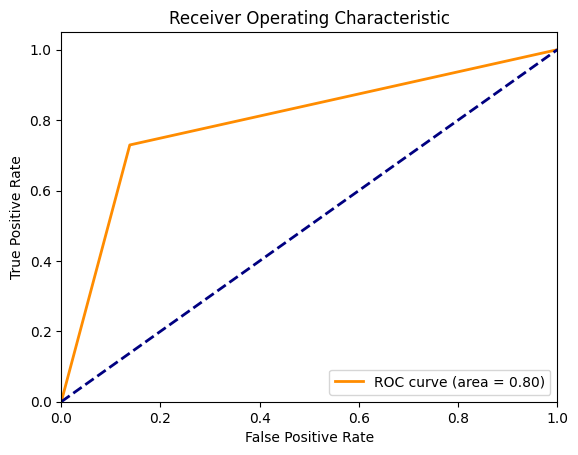

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      4546
           1       0.84      0.73      0.78      4546

    accuracy                           0.80      9092
   macro avg       0.80      0.80      0.79      9092
weighted avg       0.80      0.80      0.79      9092



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Accessibility issues new.csv', encoding='latin-1')
print("Dataset loaded.")
print(dataset.columns)
# Remove rows where the target variable has missing values
dataset = dataset.dropna(subset=['Have_Issue'])

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['Base_Reviews'] = dataset['Base_Reviews'].apply(clean_text)
dataset['Base_Reviews'].dropna(inplace=True)
dataset['Base_Reviews'] = [entry.lower() for entry in dataset['Base_Reviews']]
dataset['Base_Reviews'] = [word_tokenize(entry) for entry in dataset['Base_Reviews']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['Base_Reviews']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Issue'] = dataset['Have_Issue'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Issue']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the LSTM model
def build_LSTM_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
lstm_model = build_LSTM_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = lstm_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = lstm_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Issue", "Issue"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
Index(['Unnamed: 0', 'userName', 'Title', 'Base_Reviews', 'Rating',
       'cleaned_Review', 'Have_Issue', 'Assessability Issue Type'],
      dtype='object')
NLTK data downloaded.


<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/4095099590.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 61] Connection refused>
[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/4095099590.py:41: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the fi

Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.6310 - loss: 0.6387 - val_accuracy: 0.7993 - val_loss: 0.4476
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.7950 - loss: 0.4586 - val_accuracy: 0.8049 - val_loss: 0.4336
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.8288 - loss: 0.4091 - val_accuracy: 0.8232 - val_loss: 0.4028
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 0.8334 - loss: 0.3883 - val_accuracy: 0.8395 - val_loss: 0.3933
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8422 - loss: 0.3722 - val_accuracy: 0.8441 - val_loss: 0.3763
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.8576 - loss: 0.3574 - val_accuracy: 0.8487 - val_loss: 0.3608
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 0.8709 - loss: 0.3220 - val_accuracy: 0.8599 - val_loss: 0.3444
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.8830 - loss: 0.3108 - val_accuracy: 0.861

/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.6345 - loss: 0.6375 - val_accuracy: 0.7896 - val_loss: 0.4542
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.8043 - loss: 0.4452 - val_accuracy: 0.7922 - val_loss: 0.4491
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.8253 - loss: 0.4027 - val_accuracy: 0.8258 - val_loss: 0.4071
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.8470 - loss: 0.3740 - val_accuracy: 0.8186 - val_loss: 0.4100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.6515 - loss: 0.6370 - val_accuracy: 0.8120 - val_loss: 0.4452
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.8036 - loss: 0.4489 - val_accuracy: 0.8202 - val_loss: 0.4045
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.8244 - loss: 0.4015 - val_accuracy: 0.8166 - val_loss: 0.4289
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - accuracy: 0.6302 - loss: 0.6384 - val_accuracy: 0.8059 - val_loss: 0.4576
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.8044 - loss: 0.4454 - val_accuracy: 0.8105 - val_loss: 0.4246
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.8269 - loss: 0.4107 - val_accuracy: 0.8222 - val_loss: 0.4077
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.8419 - loss: 0.3954 - val_accuracy: 0.8344 - val_loss: 0.3902
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.8483 - loss: 0.3712 - val_accuracy: 0.8334 - val_loss: 0.3922
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.6342 - loss: 0.6407 - val_accuracy: 0.7957 - val_loss: 0.4573
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.7886 - loss: 0.4595 - val_accuracy: 0.8207 - val_loss: 0.4174
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 0.8204 - loss: 0.4177 - val_accuracy: 0.8263 - val_loss: 0.4105
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.8346 - loss: 0.3921 - val_accuracy: 0.8370 - val_loss: 0.3858
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.8487 - loss: 0.3675 - val_accuracy: 0.8365 - val_loss: 0.3807
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.8602 - loss: 0.3496 - val_accuracy: 0.8492 - val_loss: 0.3602
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.8678 - loss: 0.3275 - val_accuracy: 0.8553 - val_loss: 0.3428
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.8767 - loss: 0.3111 - val_accuracy: 0.860

/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.6470 - loss: 0.6350 - val_accuracy: 0.7957 - val_loss: 0.4613
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.7935 - loss: 0.4602 - val_accuracy: 0.8136 - val_loss: 0.4172
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.8226 - loss: 0.4276 - val_accuracy: 0.8176 - val_loss: 0.4121
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.8461 - loss: 0.3806 - val_accuracy: 0.8232 - val_loss: 0.4070
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8495 - loss: 0.3737 - val_accuracy: 0.8421 - val_loss: 0.3754
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.8570 - loss: 0.3548 - val_accuracy: 0.8329 - val_loss: 0.3894
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.6090 - loss: 0.6404 - val_accuracy: 0.7780 - val_loss: 0.4815
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.7953 - loss: 0.4631 - val_accuracy: 0.8152 - val_loss: 0.4162
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.8255 - loss: 0.4026 - val_accuracy: 0.8279 - val_loss: 0.3951
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.8381 - loss: 0.3915 - val_accuracy: 0.8401 - val_loss: 0.3883
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.8457 - loss: 0.3701 - val_accuracy: 0.8457 - val_loss: 0.3802
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8556 - loss: 0.3572 - val_accuracy: 0.8508 - val_loss: 0.3570
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.8707 - loss: 0.3265 - val_accuracy: 0.8600 - val_loss: 0.3482
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8833 - loss: 0.3021 - val_accuracy: 0.862

/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - accuracy: 0.6384 - loss: 0.6361 - val_accuracy: 0.8045 - val_loss: 0.4573
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.8001 - loss: 0.4550 - val_accuracy: 0.8284 - val_loss: 0.4048
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.8233 - loss: 0.4058 - val_accuracy: 0.8320 - val_loss: 0.3830
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.8398 - loss: 0.3857 - val_accuracy: 0.8371 - val_loss: 0.3792
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8598 - loss: 0.3590 - val_accuracy: 0.8442 - val_loss: 0.3655
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.8618 - loss: 0.3446 - val_accuracy: 0.8473 - val_loss: 0.3718
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - accuracy: 0.6155 - loss: 0.6409 - val_accuracy: 0.8055 - val_loss: 0.4521
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.7932 - loss: 0.4623 - val_accuracy: 0.8096 - val_loss: 0.4277
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.8231 - loss: 0.4182 - val_accuracy: 0.8238 - val_loss: 0.4033
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.8385 - loss: 0.3836 - val_accuracy: 0.8238 - val_loss: 0.4147
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.6249 - loss: 0.6403 - val_accuracy: 0.7800 - val_loss: 0.4898
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.7839 - loss: 0.4740 - val_accuracy: 0.8187 - val_loss: 0.4177
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8222 - loss: 0.4143 - val_accuracy: 0.8299 - val_loss: 0.3932
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.8353 - loss: 0.3863 - val_accuracy: 0.8289 - val_loss: 0.3996
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


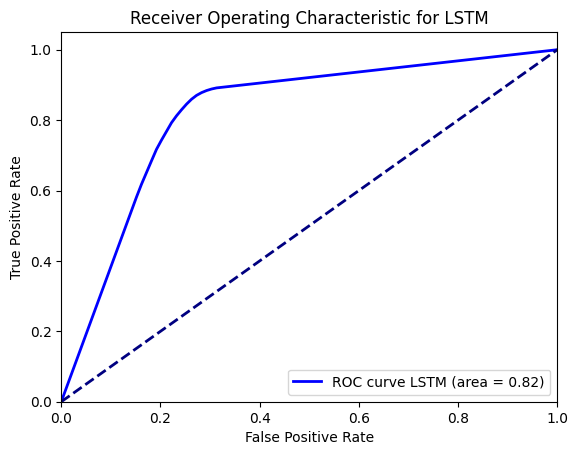

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      5453
           1       0.79      0.88      0.83      5453

    accuracy                           0.82     10906
   macro avg       0.83      0.82      0.82     10906
weighted avg       0.83      0.82      0.82     10906



In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Accessibility issues new.csv', encoding='latin-1')
print("Dataset loaded.")
print(dataset.columns)
# Remove rows where the target variable has missing values
dataset = dataset.dropna(subset=['Have_Issue'])

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['Base_Reviews'] = dataset['Base_Reviews'].apply(clean_text)
dataset['Base_Reviews'].dropna(inplace=True)
dataset['Base_Reviews'] = [entry.lower() for entry in dataset['Base_Reviews']]
dataset['Base_Reviews'] = [word_tokenize(entry) for entry in dataset['Base_Reviews']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['Base_Reviews']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Issue'] = dataset['Have_Issue'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Issue']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the LSTM model
def build_LSTM_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
lstm_model = build_LSTM_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predicted_targets = []
    all_actual_targets = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_LSTM_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predicted_targets.extend(predictions)
        all_actual_targets.extend(Test_Y)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc, all_predicted_targets, all_actual_targets

# Get ROC data
mean_fpr_lstm, mean_tpr_lstm, mean_auc_lstm, all_predictions_lstm, all_actuals_lstm = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot ROC Curve
plt.figure()
plt.plot(mean_fpr_lstm, mean_tpr_lstm, color='blue', lw=2, label='ROC curve LSTM (area = %0.2f)' % mean_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(all_actuals_lstm, all_predictions_lstm))


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Accessibility issues new.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['Base_Reviews'] = dataset['Base_Reviews'].apply(clean_text)
dataset['Base_Reviews'].dropna(inplace=True)
dataset['Base_Reviews'] = [entry.lower() for entry in dataset['Base_Reviews']]
dataset['Base_Reviews'] = [word_tokenize(entry) for entry in dataset['Base_Reviews']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['Base_Reviews']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Issue'] = dataset['Have_Issue'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Issue']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the LSTM model
def build_LSTM_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
lstm_model = build_LSTM_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predicted_targets = []
    all_actual_targets = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_LSTM_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predicted_targets.extend(predictions)
        all_actual_targets.extend(Test_Y)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc, all_predicted_targets, all_actual_targets

# Get ROC data
mean_fpr_lstm_under, mean_tpr_lstm_under, mean_auc_lstm_under, all_predictions_lstm_under, all_actuals_lstm_under = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Print classification report
print(classification_report(all_actuals_lstm_under, all_predictions_lstm_under))


Dataset loaded.
NLTK data downloaded.


<>:45: SyntaxWarning: invalid escape sequence '\['
<>:45: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/765418068.py:45: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 61] Connection refused>
[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5274/765418068.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the file

Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.6456 - loss: 0.6336 - val_accuracy: 0.5644 - val_loss: 0.7460
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.7961 - loss: 0.4564 - val_accuracy: 0.7312 - val_loss: 0.6008
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.8141 - loss: 0.4094 - val_accuracy: 0.7172 - val_loss: 0.6717
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.6429 - loss: 0.6339 - val_accuracy: 0.6787 - val_loss: 0.6044
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.7970 - loss: 0.4570 - val_accuracy: 0.6432 - val_loss: 0.7341
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.6518 - loss: 0.6286 - val_accuracy: 0.6109 - val_loss: 0.6871
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.7917 - loss: 0.4541 - val_accuracy: 0.6487 - val_loss: 0.6834
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.8357 - loss: 0.3868 - val_accuracy: 0.7715 - val_loss: 0.5191
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.8376 - loss: 0.3643 - val_accuracy: 0.7300 - val_loss: 0.6271
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.6506 - loss: 0.6299 - val_accuracy: 0.5290 - val_loss: 0.7698
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.7832 - loss: 0.4623 - val_accuracy: 0.6463 - val_loss: 0.6870
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.8164 - loss: 0.4158 - val_accuracy: 0.7764 - val_loss: 0.5362
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.8448 - loss: 0.3679 - val_accuracy: 0.7019 - val_loss: 0.6575
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.6364 - loss: 0.6258 - val_accuracy: 0.4875 - val_loss: 0.8316
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.7914 - loss: 0.4496 - val_accuracy: 0.7208 - val_loss: 0.5804
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.8279 - loss: 0.3978 - val_accuracy: 0.6817 - val_loss: 0.6884
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.6460 - loss: 0.6269 - val_accuracy: 0.5724 - val_loss: 0.7233
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.7923 - loss: 0.4522 - val_accuracy: 0.7636 - val_loss: 0.5206
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.8121 - loss: 0.4040 - val_accuracy: 0.8009 - val_loss: 0.4738
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8433 - loss: 0.3691 - val_accuracy: 0.7214 - val_loss: 0.6496
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.6428 - loss: 0.6324 - val_accuracy: 0.5205 - val_loss: 0.8025
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.7793 - loss: 0.4606 - val_accuracy: 0.7001 - val_loss: 0.6096
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.8176 - loss: 0.3996 - val_accuracy: 0.7288 - val_loss: 0.6020
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.8389 - loss: 0.3780 - val_accuracy: 0.7831 - val_loss: 0.5476
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.8522 - loss: 0.3532 - val_accuracy: 0.7172 - val_loss: 0.6684
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.6455 - loss: 0.6300 - val_accuracy: 0.6995 - val_loss: 0.5756
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.7865 - loss: 0.4611 - val_accuracy: 0.7098 - val_loss: 0.6167
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.6373 - loss: 0.6332 - val_accuracy: 0.6390 - val_loss: 0.6350
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.7845 - loss: 0.4623 - val_accuracy: 0.7685 - val_loss: 0.5224
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.8226 - loss: 0.3999 - val_accuracy: 0.7104 - val_loss: 0.6562
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.6404 - loss: 0.6286 - val_accuracy: 0.6292 - val_loss: 0.6459
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.7954 - loss: 0.4513 - val_accuracy: 0.7697 - val_loss: 0.5221
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.8200 - loss: 0.4012 - val_accuracy: 0.7166 - val_loss: 0.6126
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      4546
           1       0.83      0.70      0.76      4546

    accuracy                           0.78      9092
   macro avg       0.79      0.78      0.78      9092
weighted avg       0.79      0.78      0.78      9092



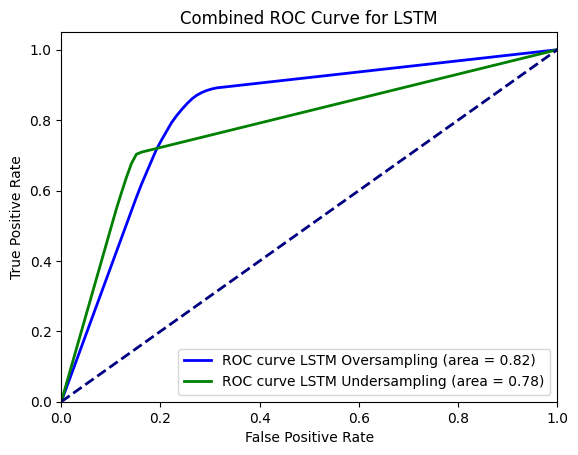

In [5]:
# Plot Combined ROC Curve
plt.figure()
plt.plot(mean_fpr_lstm, mean_tpr_lstm, color='blue', lw=2, label='ROC curve LSTM Oversampling (area = %0.2f)' % mean_auc_lstm)
plt.plot(mean_fpr_lstm_under, mean_tpr_lstm_under, color='green', lw=2, label='ROC curve LSTM Undersampling (area = %0.2f)' % mean_auc_lstm_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for LSTM')
plt.legend(loc="lower right")
plt.show()


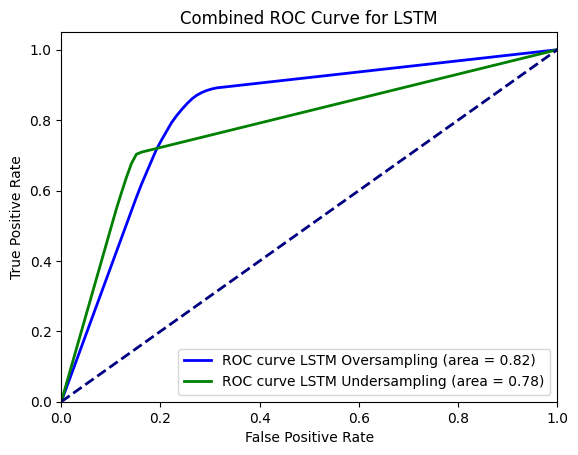

In [6]:
import matplotlib.pyplot as plt
# Plot Combined ROC Curve
plt.figure()
plt.plot(mean_fpr_lstm, mean_tpr_lstm, color='blue', lw=2, label='ROC curve LSTM Oversampling (area = %0.2f)' % mean_auc_lstm)
plt.plot(mean_fpr_lstm_under, mean_tpr_lstm_under, color='green', lw=2, label='ROC curve LSTM Undersampling (area = %0.2f)' % mean_auc_lstm_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for LSTM')
plt.legend(loc="lower right")
# Save the plot
plt.savefig('combined_roc_curve_lstm.png', dpi=300)
plt.show()